Homework 11 Key
====
#### CHE 116: Numerical Methods and Statistics
Version 1.0 (3/14/2016)

----

Problem 1 (100 Points)
====

Write a module to package your CHE 116 methods. You will create two files: `stats.py` and `regression.py`. Your `stats.py` file will contain the confidence interval function from Unit 13, Lecture 1. You will write two regression functions in `regression.py`: `linear_regress` and `nonlinear_regress`. Here are their attributes:

`linear_regress`:
  1. Takes in an x matrix of data and y values
  3. Performs a regression and return standard errors of the fit coefficients and standard error in residual
  2. Takes in a True/False variable which indicates whether or not to create plots
  3. If creating plots, it should create a single plot (!) with as many subplots as needed to justify the regression
  4. Takes in a pvalue variable, which if True computes and returns $p$-values for each of the coefficients using a t-test hypothesis test
  
`nonlinear_regress`:
  1. Takes in an x matrix of data, a function which takes in (beta, x) and returns predicted y, an initial guess for beta, and y values
  3. Performs a regression and return standard errors of the fit coefficients and standard error in residual
  2. Takes in a True/False variable which indicates whether or not to create plots
  3. If creating plots, it should create a single plot (!) with as many subplots as needed to justify the regression
  4. Takes in a pvalue variable, which if True computes and returns $p$-values for each of the coefficients using a t-test hypothesis test
  5. Take in a nonconvex variable, which if True causes the method to use basin_hopping for minimizing SSR
  
You should be able to install your resulting CHE 116 module using the `pip` command as shown in lecture. 

----

I have been intentionally vague on the specifications. It is up to you to write detailed documentation and specifications about your function. You will be graded according to the following:

1. Your module can be installed and imported [20 Points]
2. Your module and functions are well-documented, including examples, returns and parameters descriptions. [20 Points]
3. Your functions behave correctly on usual data and perform plots/statistics [50 Points]
4. Your functions respond gracefully to bad inputs and give warnings/notice if it fails to fit for any reason [10 Points]

----

**You should submit a zipped folder containing your module and notebook demonstrating how to use your function.**

Folder Layout Answer
===

In [4]:
#NOTE - you can make these folders in your OS if you want instead.
import os

os.mkdir('che116-package')
os.mkdir('che116-package/che116')

In [6]:
%%writefile che116-package/setup.py

from setuptools import setup

setup(name = 'che116', #the name for install purposes
      author = 'Andrew White', #for your own info
      description = 'A collection of useful functions from CHE 116', #displayed when install/update
      version='1.0',
      packages=['che116']) #This name should match the directory where you put your code

Writing che116-package/setup.py


In [7]:
%%writefile che116-package/che116/__init__.py
'''Contains two files: regression.py and stats.py for now'''

Writing che116-package/che116/__init__.py


Regression Functions - Answer
----

In [33]:
%%writefile che116-package/che116/regression.py

import numpy as np
import scipy.stats as ss
import scipy.linalg as linalg
import numdifftools as nd
import scipy.optimize as opt
import matplotlib.pyplot as plt

def linear_regress(x_mat, y, plots=False, pvalues=False):
    '''Perform a linear regression given the x matrix and y data.
    
    Examples
    --------
        #make some data
        N = 25
        x_mat = np.column_stack( (np.ones(N), np.linspace(0,10,N)) )
        y = x_mat.dot([2, 3]) + np.random.normal(size=N)
        
        #regress it
        beta, beta_se, resid_se, p_values = linear_regress(x_mat, y, plots=True, pvalues=True)
            
        #compare with our coefficients
        print(beta[0], 2)
        print(beta[1], 3)
        
    
    Parameters
    ----------
        x_mat : numpy array
            The matrix of data. Each row should be a data point and each column a dimension
        y : numpy array
            The single-dimensional output data
        plot : bool
            Wheter or not to make plots
        pvalues : bool
            Wheter or not to compute p-values for each regressed coefficient
    Returns
    -------
        tuple(beta, beta_se, resid_se, p_values)
            Returns a tuple containing the fit coefficients, the standard error in those coefficients, 
            the standard error in the residuals and if pvalues is True, the p-values for each coefficient
            from a t-test.
    
    '''
    #perform checks
    
    #attempt reshape
    if(len(np.shape(x_mat)) == 1):
        x_mat = np.reshape(x_mat, (len(x_mat), 1))
    
    #is data shaped correctly
    N, D = np.shape(x_mat)
    
    if(N < D):
        raise ValueError('Your matrix implies more fit coefficients than data points. Maybe tranpose it?')
    #check if shapes are consistent
    if(N != np.shape(y)[0]):
        raise ValueError('The number of rows in x_mat must match the number of elements in y')

    beta = linalg.inv(x_mat.transpose().dot(x_mat)).dot(x_mat.transpose()).dot(y)
    yhat = x_mat.dot(beta)
    resids = yhat - y
    
    _,shapiro_pvalue = ss.shapiro(resids)
    if(shapiro_pvalue < 0.05):
        print('Warning: Residuals do not appear to be normal. Shapiro-Wilks p-value: {}'.format(shapiro_pvalue))
    
    resid_se2 = np.sum(resids**2) / (N - D)
    beta_se = np.sqrt(np.diag(linalg.inv(x_mat.transpose().dot(x_mat))) * resid_se2)
    
    if(pvalues):
        pvalues = 1 - (ss.t.cdf(beta / beta_se, N - D) - ss.t.cdf(-beta / beta_se, N - D))
    else:
        pvalues = None
    
    if(plots):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

        axs[0].hist(resids)
        axs[0].set_xlabel('residuals')
        axs[0].set_ylabel('counts')
        axs[0].set_title('Residual Histogram')
        
        axs[1].plot(y, yhat, 'o')
        axs[1].plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], 'r--')
        axs[1].set_xlabel('Predicted')
        axs[1].set_ylabel('Observed')
        axs[1].set_title('Fit')
        
        fig.tight_layout()
        plt.show()
    
    return beta, beta_se, np.sqrt(resid_se2), pvalues

def nonlinear_regress(x_mat, y, fxn, beta0, plots=False, pvalues=False, nonconvex=False):
    '''Perform a nonlinear regression given the x matrix, y data, fxn, and initial guess for parameters.
    
    Examples
    --------
        #make some data
        #equation is 2 * x_1 + 3^x_2
        N = 25
        x_mat = np.column_stack( (np.linspace(-2,5,N), np.linspace(0,4,N)) )
        y = x_mat[:,0] *2 + 3 ** x_mat[:,1]  + np.random.normal(size=N)

        #create function to fit
        def fxn(beta, x):
            return beta[0] * x[:,0] + beta[1] ** x[:,1]

            #regress it
        beta, beta_se, resid_se, p_values = nonlinear_regress(x_mat, y, fxn, beta0=[1,1], plots=True, pvalues=True)
        print(beta)
    
    Parameters
    ----------
        x_mat : numpy array
            The matrix of data. Each row should be a data point and each column a dimension
        fxn : function
            A function which takes in two arguments: beta, x and returns predicted y values.
        y : numpy array
            The single-dimensional y data
        plot : bool
            Wheter or not to make plots
        pvalues : bool
            Wheter or not to compute p-values for each regressed coefficient
    Returns
    -------
        tuple(beta, beta_se, resid_se, p_values)
            Returns a tuple containing the fit coefficients, the standard error in those coefficients, 
            the standard error in the residuals and if pvalues is True, the p-values for each coefficient
            from a t-test.
    
    '''
    #perform checks
    
    #attempt reshape
    if(len(np.shape(x_mat)) == 1):
        x_mat = np.reshape(x_mat, (len(x_mat), 1))
    
    
    #is data shaped correctly
    N,_ = np.shape(x_mat)
    D = len(beta0)
    if(N < D):
        raise ValueError('Your matrix implies more fit coefficients than data points. Maybe tranpose it?')
    #check if shapes are consistent
    if(N != np.shape(y)[0]):
        raise ValueError('The number of rows in x_mat must match the number of elements in y')

    #create SSR function to minimize
    def SSR(beta):
        yhat = fxn(beta, x_mat)
        return np.sum((y - yhat)**2)
    if(nonconvex):
        result = opt.basinhopping(SSR, x0=beta0, niter=1000)
    else:
        result = opt.minimize(SSR, x0=beta0)
    
    beta = result.x
    yhat = fxn(beta, x_mat)
    resids = yhat - y
    
    _,shapiro_pvalue = ss.shapiro(resids)
    if(shapiro_pvalue < 0.05):
        print('Warning: Residuals do not appear to be normal. Shapiro-Wilks p-value: {}'.format(shapiro_pvalue))
    
    resid_se2 = np.sum(resids**2) / (N - D)
    df = nd.Gradient(fxn)
    F = df(beta, x_mat)
    beta_se = np.sqrt(np.diag(linalg.inv(F.transpose().dot(F))) * resid_se2)
    
    if(pvalues):
        pvalues = 1 - (ss.t.cdf(beta / beta_se, N-D) - ss.t.cdf(-beta / beta_se, N-D))
    else:
        pvalues = None
    
    if(plots):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

        axs[0].hist(resids)
        axs[0].set_xlabel('residuals')
        axs[0].set_ylabel('counts')
        axs[0].set_title('Residual Histogram')
        
        axs[1].plot(y, yhat, 'o')
        axs[1].plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], 'r--')
        axs[1].set_xlabel('Predicted')
        axs[1].set_ylabel('Observed')
        axs[1].set_title('Fit')
        
        fig.tight_layout()
        plt.show()
    return beta, beta_se, np.sqrt(resid_se2), pvalues

Overwriting che116-package/che116/regression.py


Stats.py file
---

In [15]:
%%writefile che116-package/che116/stats.py

import scipy.stats as ss
import numpy as np

def conf_interval(data, interval_type='double', confidence=0.95):
    '''This function takes in the data and computes a confidence interval
    
    Examples
    --------

        data = [4,3,2,5]
        center, width = conf_interval(data)
        print('The mean is {} +/- {}'.format(center, width))
    
    Parameters
    ----------
        data : list
            The list of data points
        interval_type : str
            What kind of confidence interval. Can be double, upper, lower.
        confidence : float
            The confidence of the interval
    Returns
    -------
    center, width
        Center is the mean of the data. Width is the width of the confidence interval. 
        If a lower or upper is specified, width is the upper or lower value.
    '''
    
    if(len(data) < 3):
        raise ValueError('Not enough data given. Must have at least 3 values')
    if(interval_type not in ['upper', 'lower', 'double']):
        raise ValueError('I do not know how to make a {} confidence interval'.format(interval_type))
    if(0 > confidence or confidence > 1):
        raise ValueError('Confidence must be between 0 and 1')
    
    center = np.mean(data)
    s = np.std(data, ddof=1)
    if interval_type == 'lower':
        ppf = confidence
    elif interval_type == 'upper':
        ppf = 1 - confidence
    else:
        ppf = 1 - (1 - confidence) / 2
    t = ss.t.ppf(ppf, len(data))
    width = s / np.sqrt(len(data)) * t
    
    if interval_type == 'lower' or interval_type == 'upper':
        width = center + width
    return center, width

Overwriting che116-package/che116/stats.py


Install
----

In [16]:
%system pip install -e che116-package

['Obtaining file:///home/jovyan/work/che116-package',
 'Installing collected packages: che116',
 '  Running setup.py develop for che116',
 'Successfully installed che116-1.0']

Testing
===

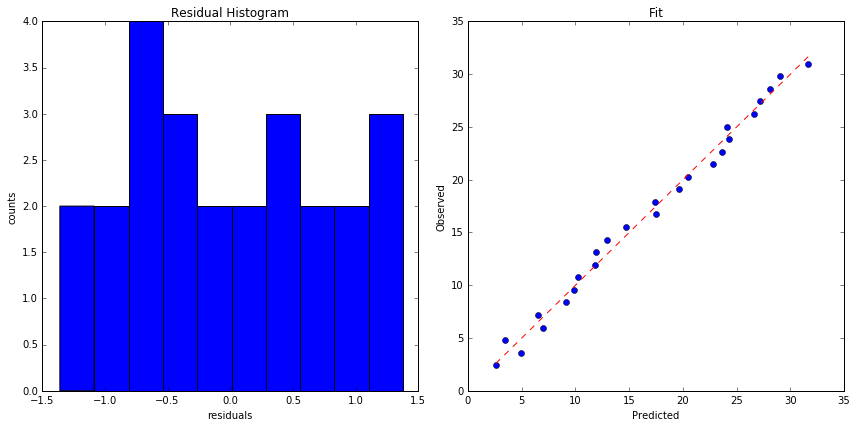

2.42252106797 2
2.85669844633 3


In [1]:
import numpy as np
import scipy.stats as ss
import scipy.linalg as linalg
import numdifftools as nd
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

from che116 import regression

#make some data
N = 25
x_mat = np.column_stack( (np.ones(N), np.linspace(0,10,N)) )
y = x_mat.dot([2, 3]) + np.random.normal(size=N)
        
#regress it
beta, beta_se, resid_se, p_values = regression.linear_regress(x_mat, y, plots=True, pvalues=True)
        
#compare with our coefficients
print(beta[0], 2)
print(beta[1], 3)

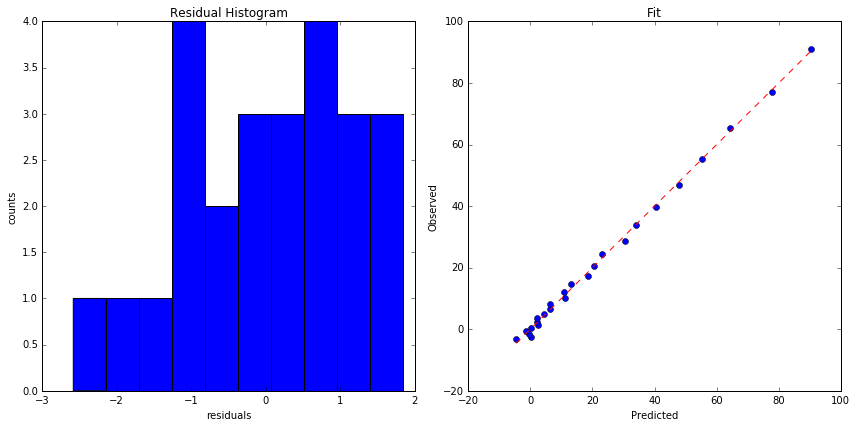

[ 2.11287571  2.99635894]


In [2]:
#make some data
#equation is 2 * x_1 + 3^x_2
N = 25
x_mat = np.column_stack( (np.linspace(-2,5,N), np.linspace(0,4,N)) )
y = x_mat[:,0] *2 + 3 ** x_mat[:,1]  + np.random.normal(size=N)

#create function to fit
def fxn(beta, x):
    return beta[0] * x[:,0] + beta[1] ** x[:,1]
                    
    #regress it
beta, beta_se, resid_se, p_values = regression.nonlinear_regress(x_mat, y, fxn, beta0=[1,1], plots=True, pvalues=True)
print(beta)

Testing Error Problems
----

Invalid input
---

In [3]:
#Can it handle 1D data ?

N = 25
x = np.linspace(0,4,N)
y = 3 * x - 2  + np.random.normal(size=N)

print(len(np.shape(x)))
regression.linear_regress(x, y)

1


(array([ 2.31122483]), array([ 0.12902058]), 1.5052401529161412, None)

In [4]:
#can it handle bad shape data correctly?
N = 25
x_mat = np.column_stack( (np.ones(N), np.linspace(0,10,N)) )
y = x_mat.dot([2, 3]) + np.random.normal(size=N)
        
regression.linear_regress(np.transpose(x_mat), y, plots=True, pvalues=True)

ValueError: Your matrix implies more fit coefficients than data points. Maybe tranpose it?

In [5]:
#does it check for bad residuals?
N = 25
x = np.linspace(0,4,N)
y = 3 * x**3 - 2  + np.random.normal(size=N)
x = np.reshape(x, (len(x), 1))
regression.linear_regress(x, y)

(array([ 29.27278378]), array([ 2.71626465]), 31.68975429862634, None)

Docstrings
===

In [6]:
import che116
help(che116)

Help on package che116:

NAME
    che116 - Contains two files: regression.py and stats.py for now

PACKAGE CONTENTS
    regression
    stats

FILE
    /home/jovyan/work/che116-package/che116/__init__.py




In [7]:
help(regression.linear_regress)

Help on function linear_regress in module che116.regression:

linear_regress(x_mat, y, plots=False, pvalues=False)
    Perform a linear regression given the x matrix and y data.
    
    Examples
    --------
        #make some data
        N = 25
        x_mat = np.column_stack( (np.ones(N), np.linspace(0,10,N)) )
        y = x_mat.dot([2, 3]) + np.random.normal(size=N)
        
        #regress it
        beta, beta_se, resid_se, p_values = linear_regress(x_mat, y, plots=True, pvalues=True)
            
        #compare with our coefficients
        print(beta[0], 2)
        print(beta[1], 3)
        
    
    Parameters
    ----------
        x_mat : numpy array
            The matrix of data. Each row should be a data point and each column a dimension
        y : numpy array
            The single-dimensional output data
        plot : bool
            Wheter or not to make plots
        pvalues : bool
            Wheter or not to compute p-values for each regressed coefficient
   

In [8]:
help(regression.nonlinear_regress)

Help on function nonlinear_regress in module che116.regression:

nonlinear_regress(x_mat, y, fxn, beta0, plots=False, pvalues=False, nonconvex=False)
    Perform a nonlinear regression given the x matrix, y data, fxn, and initial guess for parameters.
    
    Examples
    --------
        #make some data
        #equation is 2 * x_1 + 3^x_2
        N = 25
        x_mat = np.column_stack( (np.linspace(-2,5,N), np.linspace(0,4,N)) )
        y = x_mat[:,0] *2 + 3 ** x_mat[:,1]  + np.random.normal(size=N)
    
        #create function to fit
        def fxn(beta, x):
            return beta[0] * x[:,0] + beta[1] ** x[:,1]
    
            #regress it
        beta, beta_se, resid_se, p_values = nonlinear_regress(x_mat, y, fxn, beta0=[1,1], plots=True, pvalues=True)
        print(beta)
    
    Parameters
    ----------
        x_mat : numpy array
            The matrix of data. Each row should be a data point and each column a dimension
        fxn : function
            A function which t

Grading
====


* Can Install - 25 Points
* Package setup.py documentation (author,description, etc) - 5 Points
* regression.py docstrings on methods - 15 Points
* Included Stat.py - 5 Points
* Can set plots, pvalues, returns error, pvales, coefficients. Followed function definition instructions - 15 Points
* Using cells below, check correctness. Nonlinear,Linear are correct - 20 Points
* Uses at least one exception in code - 5 Points
* Plots yhat vs y, residual histogram - 10 Points

Extra Credit:

* Uses two exceptions in both linear and non-linear - 5 Points
* Check residual normality - 5 Points
* Deals with nonconvex vs convex - 5 Points
* Plots more than 2 things, only if meaningful - 5 Points
* Deals with 1D x data - 5 Points
* Documented __init__.py file - 5 Points
* Any other nice things, at most - 5 Points

In [9]:
#create wrapper so we can standardize function calls

def linear(x, y, plots=False, pvalues=False):
    #Change this to how the author wrote theirs - this is only an example
    #CHANGE HERE
    beta, beta_se, resid_se, p_values = regression.linear_regress(x_mat=x, y=y, plots=plots, pvalues=pvalues)
    #STOP
    return beta, beta_se, resid_se, p_values
    
def nonlinear(x, y, fxn, b0, plots=False, pvalues=False):
    #Change this to how the author wrote theirs - this is only an example
    #CHANGE HERE
    beta, beta_se, resid_se, p_values  = regression.nonlinear_regress(x_mat=x, y=y, plots=plots, pvalues=pvalues, beta0=b0, fxn=fxn)
    #STOP
    return beta, beta_se, resid_se, p_values

In [10]:
#test if linear is correct
N = 25
x = np.linspace(0,4,N)
y = 3 * x 
x = np.reshape(x, (len(x), 1))
beta = linear(x, y)

assert abs(beta[0] - 3) < 0.001
print('GOOD!')

GOOD!


/opt/conda/lib/python3.5/site-packages/scipy/stats/morestats.py:1326: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [11]:
#test if error is reasonable
#test if linear is correct
N = 25
x = np.linspace(0,4,N)
y = 3 * x + np.random.normal(size=N)
x = np.reshape(x, (len(x), 1))
beta, beta_se,_,_ = linear(x, y)

#check if true beta is within 95% confidence interval (this code will fail accidentally 5% of the time! CHECK IT A FEW TIMES)
assert abs(beta[0] - 3) < beta_se[0] * 2
print('GOOD!')

GOOD!


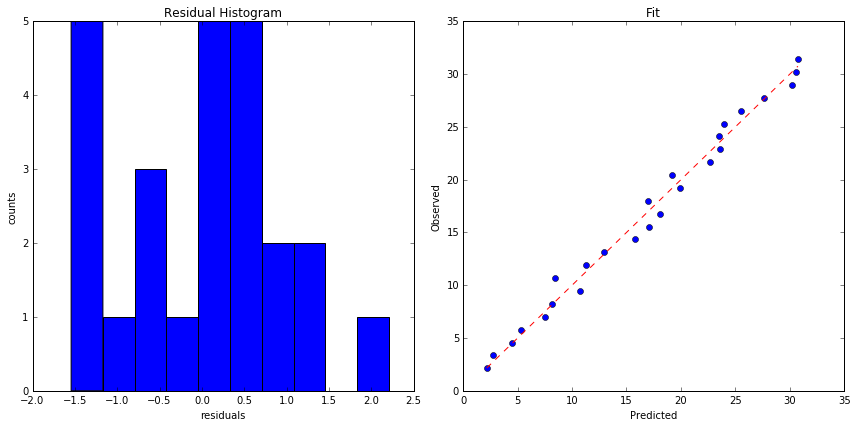

2.12892584219 2
2.9300278685 3


In [12]:
#test multiple dimensions and with plots, just visually examine this!
#make some data
N = 25
x_mat = np.column_stack( (np.ones(N), np.linspace(0,10,N)) )
y = x_mat.dot([2, 3]) + np.random.normal(size=N)
        
#regress it
beta, beta_se, resid_se, p_values = linear(x_mat, y, plots=True, pvalues=True)
        
#compare with our coefficients
print(beta[0], 2)
print(beta[1], 3)

In [18]:
#test if nonlinear is correct
N = 25
x = np.linspace(0,4,N)
y = 3 * x ** 4
x = np.reshape(x, (len(x), 1))
beta, _,_,_ = nonlinear(x, y, fxn=lambda b,x: np.reshape(b[0] * x**b[1], len(y)), b0=[2.9, 4.1])

assert abs(beta[0] - 3) < 0.001
assert abs(beta[1] - 4) < 0.001
print('GOOD!')

GOOD!


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in power
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in power
/opt/conda/lib/python3.5/site-packages/scipy/optimize/optimize.py:562: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in power


In [19]:
#test if nonlinear error is correct
N = 25
x = np.linspace(0,4,N)
y = 3 * x ** 4 + np.random.normal(size=N)
x = np.reshape(x, (len(x), 1))
beta, beta_se,_,_ = nonlinear(x, y, fxn=lambda b,x: np.reshape(b[0] * x**b[1], len(y)), b0=[2.9, 4.1])

assert abs(beta[0] - 3) < beta_se[0] * 2
assert abs(beta[1] - 4) < beta_se[1] * 2
print('GOOD!')

GOOD!


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in power
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in power
/opt/conda/lib/python3.5/site-packages/scipy/optimize/optimize.py:562: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in power
